In this file, I am going to implement a phone recognizer by neural network.

First thing is to get the training and testing data. In the documentation of TIMIT database, there is a section called "Core Test Set", which contains 192 utterances from 24 speakers. I am going to use this set as my test set now for the purpose of speed. I will use the whole TIMIT database as my test set later.

Here is a table of core test set:

| Dialect |    Male    | Female | #Texts/Speaker | #Total Texts |
|---------|:----------:|:------:|:--------------:|:------------:|
|    1    | DAB0, WBT0 |  ELC0  |       8        |      24      |
|    2    | TAS1, WEW0 |  PAS0  |       8        |      24      |
|    3    | JMP0, LNT0 |  PKT0  |       8        |      24      |
|    4    | LLL0, TLS0 |  JLM0  |       8        |      24      |
|    5    | BPM0, KLT0 |  NLP0  |       8        |      24      |
|    6    | CMJ0, JDH0 |  MGD0  |       8        |      24      |
|    7    | GRT0, NJM0 |  DHC0  |       8        |      24      |
|    8    | JLN0, PAM0 |  MLD0  |       8        |      24      |
|  Total  |     16     |   8    |                |     192      |

The metadata (like file name, speaker id, etc.) of the training and testing data are stored in the file `train_data.csv` and `test_data.csv`. So the first thing is to load these two files.


In [2]:
import os  # for environment variables
import pandas as pd
from pathlib import Path
import librosa  # for audio processing
import numpy as np
import sounddevice as sd  # for audio playing
from python_speech_features import mfcc  # for MFCC feature extraction

In [3]:
# Load `train_data.csv` and `test_data.csv` as pandas `DataFrames`
TIMIT = Path(os.environ["TIMIT"])
train_data = pd.read_csv(TIMIT / "train_data.csv")
test_data = pd.read_csv(TIMIT / "test_data.csv")

# Take a look at the first few rows of `train_data`
train_data.head()

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
0,1.0,TRAIN,DR4,MMDM0,SI681.WAV.wav,TRAIN/DR4/MMDM0/SI681.WAV.wav,TRAIN\\DR4\\MMDM0\\SI681.WAV.wav,True,True,False,False,False
1,2.0,TRAIN,DR4,MMDM0,SI1311.PHN,TRAIN/DR4/MMDM0/SI1311.PHN,TRAIN\\DR4\\MMDM0\\SI1311.PHN,False,False,False,True,False
2,3.0,TRAIN,DR4,MMDM0,SI1311.WRD,TRAIN/DR4/MMDM0/SI1311.WRD,TRAIN\\DR4\\MMDM0\\SI1311.WRD,False,False,True,False,False
3,4.0,TRAIN,DR4,MMDM0,SX321.PHN,TRAIN/DR4/MMDM0/SX321.PHN,TRAIN\\DR4\\MMDM0\\SX321.PHN,False,False,False,True,False
4,5.0,TRAIN,DR4,MMDM0,SX321.WRD,TRAIN/DR4/MMDM0/SX321.WRD,TRAIN\\DR4\\MMDM0\\SX321.WRD,False,False,True,False,False


From the first few lines of `train_data.csv`, we can see that the data is stored in the following format:
`index, test_or_train, dialect_region, speaker_id, filename, path_from_data_dir, path_from_data_dir_windows, is_converted_audio, is_audio, is_word_file, is_phonetic_file, is_sentence_file`

Here is a brief explanation of each column:
- `index`: the index of the data
- `test_or_train`: whether the data is in the test set or the training set
- `dialect_region`: the dialect region of the speaker
- `speaker_id`: the id of the speaker
- `filename`: the filename of the data
- `path_from_data_dir`: the path of the data from the `data` directory
- `path_from_data_dir_windows`: the path of the data from the `data` directory in Windows
- `is_converted_audio`: whether the data is converted to `.wav` format
- `is_audio`: whether the data is audio
- `is_word_file`: whether the data is a word file
- `is_phonetic_file`: whether the data is a phonetic file
- `is_sentence_file`: whether the data is a sentence file

Since we only care about phonetic information, the file types we care about are `.phn` and `.wav`. The columns to filter them are `is_converted_audio` and `is_phonetic_file`. For finding files, the important column is `path_from_data_dir`. For the `test_data.csv`, since we want to have a core test set, the `speaker_id` is also important.

In [4]:
# First, deal with the training set

# Get the rows where `is_converted_audio` or `is_phonetic_file` equal to `true`
train_data = train_data[
    (train_data["is_converted_audio"] == True)
    | (train_data["is_phonetic_file"] == True)
]

# Have a `Series` of the paths without extensions to the files
train_path_no_ext = train_data["path_from_data_dir"].str.split(".").str[0]
train_path_no_ext.drop_duplicates(inplace=True)
# Reset the index of `train_path_no_ext`
train_path_no_ext.reset_index(drop=True, inplace=True)

# Now do the same thing to get the path_no_ext for the test set
# First, filter the `speaker_id`, the speakers in the core test set are MDAB0, MWBT0, FELC0, MTAS1, MWEW0, FPAS0, MJMP0, MLNT0, FPKT0, MLLL0, MTLS0, FJLM0, MBPM0, MKLT0, FNLP0, MCMJ0, MJDH0, FMGD0, MGRT0, MNJM0, FDHC0, MJLN0, MPAM0, FMLD0
test_data = test_data[
    test_data["speaker_id"].isin(
        [
            "MDAB0",
            "MWBT0",
            "FELC0",
            "MTAS1",
            "MWEW0",
            "FPAS0",
            "MJMP0",
            "MLNT0",
            "FPKT0",
            "MLLL0",
            "MTLS0",
            "FJLM0",
            "MBPM0",
            "MKLT0",
            "FNLP0",
            "MCMJ0",
            "MJDH0",
            "FMGD0",
            "MGRT0",
            "MNJM0",
            "FDHC0",
            "MJLN0",
            "MPAM0",
            "FMLD0",
        ]
    )
]

In [5]:
test_path_no_ext = (
    test_data["path_from_data_dir"].str.split(".").str[0].drop_duplicates()
)
print(test_path_no_ext)

50       TEST/DR4/MTLS0/SX290
51        TEST/DR4/MTLS0/SX20
52       TEST/DR4/MTLS0/SI740
53      TEST/DR4/MTLS0/SI2000
54       TEST/DR4/MTLS0/SX110
                ...          
8357     TEST/DR8/MPAM0/SX109
8359    TEST/DR8/MPAM0/SI1189
8361     TEST/DR8/MPAM0/SX379
8367       TEST/DR8/MPAM0/SA1
8368       TEST/DR8/MPAM0/SA2
Name: path_from_data_dir, Length: 240, dtype: object


Now we've got the paths of the data we want. The next step is to load the data. For `.wav` files, we can use `librosa.load` to read the data. For `.phn` files, it's pretty much just text files with the format `start_time end_time phoneme new_line`, so we can use `numpy.loadtxt` to read the data.

In [6]:
# Creating a new dataframe to store the information of the training set
train_data_new = pd.DataFrame(
    columns=[
        "class",
        "phonetic_transcription",
        "wav_array",
    ]
)

wavs = []
transcriptions = []
# Iterate through the rows of `train_path_no_ext`
for path_no_ext in train_path_no_ext:
    wav_path = TIMIT / "data" / Path(path_no_ext + ".WAV.wav")
    wav, samplerate = librosa.load(
        wav_path, sr=None
    )  # set `sr=None` to get the original sampling rate
    phn_path = TIMIT / "data" / Path(path_no_ext + ".phn")
    with open(phn_path, "r") as f:
        for line in f:
            start, end, transcription = line.split()
            start, end = int(start), int(end)
            wavs.append(wav[start:end])
            transcriptions.append(transcription)
# Concat `wavs` and `transcriptions` to `train_data_new`
train_data_new = pd.concat(
    [
        train_data_new,
        pd.DataFrame({"wav_array": wavs, "phonetic_transcription": transcriptions}),
    ],
    ignore_index=True,
)

In [7]:
# Take a look at the first few rows of `train_data_new`
train_data_new.head()

,class,phonetic_transcription,wav_array
0,NaN,h#,"[-0.00021362305, 6.1035156e-05, 3.0517578e-05,..."
1,NaN,w,"[0.0002746582, 0.00033569336, 0.00024414062, 0..."
2,NaN,ix,"[-0.0026245117, -0.0028076172, -0.0032043457, ..."
3,NaN,dcl,"[-0.00064086914, -0.000579834, -0.00061035156,..."
4,NaN,s,"[-0.0033569336, 0.0012207031, -0.00033569336, ..."


In [8]:
# Randomly sample 1 row from `train_data_new` and given the transcription, play the audio
row = train_data_new.sample(1)
sd.play(row["wav_array"].values[0], samplerate=16000)
print(row["phonetic_transcription"].values[0])


uh


In [9]:
# Calculate the mean length of the `wav_array`
print(f"Mean length of `wav_array`: {train_data_new['wav_array'].apply(len).mean()}")
# Calculate the standard deviation of the length of the `wav_array`
print(f"Standard deviation of `wav_array`: {train_data_new['wav_array'].apply(len).std()}")

Mean length of `wav_array`: 1279.5690140049694
Standard deviation of `wav_array`: 1016.2359232286784


<AxesSubplot: >

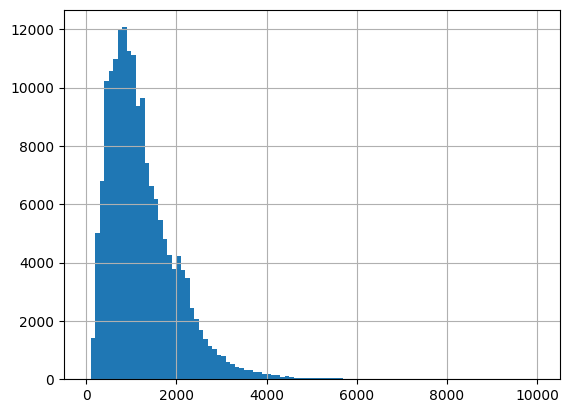

In [10]:
# Visualize the distribution of the length of `way_array`, and make the x-axis range from 0 to 6000
train_data_new["wav_array"].apply(len).hist(range=[0, 10000], bins=100)

In [11]:
# To make all the features with the same length, we need to use `librosa` to stretch or shrink the `wav_array` to the same length. Because the mean length of `wav_array` is 1279.5, we will stretch the `wav_array` to the length of 1024. And add a new column `wav_array_stretched` to `train_data_new` to store the stretched `wav_array`
def stretch_signal(signal):
    # Set n_fft to be no larger than the length of the signal
    n_fft = min(len(signal), 512)  # or some other value that is appropriate for your data
    return librosa.effects.time_stretch(signal, rate=(len(signal) / 1024), n_fft=n_fft)

train_data_new["wav_array_stretched"] = train_data_new["wav_array"].apply(stretch_signal)

In [12]:
# Take a look at the first few rows of `train_data_new`
train_data_new.head()

,class,phonetic_transcription,wav_array,wav_array_stretched
0,NaN,h#,"[-0.00021362305, 6.1035156e-05, 3.0517578e-05,...","[-0.00019364445, 5.1276224e-05, 2.9005332e-05,..."
1,NaN,w,"[0.0002746582, 0.00033569336, 0.00024414062, 0...","[0.00024678966, 0.00030001946, 0.00020417714, ..."
2,NaN,ix,"[-0.0026245117, -0.0028076172, -0.0032043457, ...","[-0.0026235995, -0.0028057476, -0.00320173, -0..."
3,NaN,dcl,"[-0.00064086914, -0.000579834, -0.00061035156,...","[-0.00064856844, -0.00059573905, -0.00062759, ..."
4,NaN,s,"[-0.0033569336, 0.0012207031, -0.00033569336, ...","[-0.004305704, 0.0014972175, -0.00016100431, -..."


In [13]:
# Randomly sample 1 row from `train_data_new` and given the transcription, play the audio
row = train_data_new.sample(1)
sd.play(row["wav_array_stretched"].values[0], samplerate=16000)
print(row["phonetic_transcription"].values[0])


ax


In [14]:
# Take a look at the length of the `wav_array_stretched`
train_data_new["wav_array_stretched"].apply(len)

0         1024
1         1024
2         1024
3         1024
4         1024
          ... 
177075    1024
177076    1024
177077    1024
177078    1024
177079    1024
Name: wav_array_stretched, Length: 177080, dtype: int64

In [15]:
# Calculate the MFCC of the `wav_array_stretched`
train_data_new["mfcc"] = train_data_new["wav_array_stretched"].apply(
    lambda x: mfcc(x, samplerate=16000)
)

In [16]:
# Take a look at the first few mfccs
train_data_new["mfcc"].head()

0    [[-14.141403380124403, -32.142537287740325, -6...
1    [[-11.325372929549259, 11.79059675707445, 3.64...
2    [[-8.633501664529303, 5.725676477768363, -9.82...
3    [[-11.588682391507778, -23.473268289222037, 2....
4    [[-4.460912743378205, -47.43519524861441, 13.6...
Name: mfcc, dtype: object

In [17]:
# Check the shape of the first 5 mfccs
train_data_new["mfcc"].apply(lambda x: x.shape).head()

0    (5, 13)
1    (5, 13)
2    (5, 13)
3    (5, 13)
4    (5, 13)
Name: mfcc, dtype: object

In [18]:
# Calculate the delta and delta-delta of the MFCC
train_data_new["mfcc_delta"] = train_data_new["mfcc"].apply(
    lambda x: librosa.feature.delta(x)
)

train_data_new["mfcc_delta2"] = train_data_new["mfcc"].apply(
    lambda x: librosa.feature.delta(x, order=2)
)

In [19]:
# Vecterize the MFCC, MFCC delta and MFCC delta-delta into a single vector called `mfcc_vect`
# Reshape the `mfcc`, `mfcc_delta` and `mfcc_delta2` to be 1D array and concatenate them into a single vector
train_data_new["mfcc_vect"] = train_data_new.apply(
    lambda x: np.concatenate(
        (
            x["mfcc"].reshape(-1),
            x["mfcc_delta"].reshape(-1),
            x["mfcc_delta2"].reshape(-1),
        )
    ),
    axis=1,
)

In [20]:

# Take a look at the shape of the first few `mfcc_vect`
train_data_new["mfcc_vect"].head().apply(lambda x: x.shape)

0    (195,)
1    (195,)
2    (195,)
3    (195,)
4    (195,)
Name: mfcc_vect, dtype: object

In [21]:
train_data_new.head()

,class,phonetic_transcription,wav_array,wav_array_stretched,mfcc,mfcc_delta,mfcc_delta2,mfcc_vect
0,NaN,h#,"[-0.00021362305, 6.1035156e-05, 3.0517578e-05,...","[-0.00019364445, 5.1276224e-05, 2.9005332e-05,...","[[-14.141403380124403, -32.142537287740325, -6...","[[3.2126307175321687, 3.2126307175321687, 3.21...","[[0.021265416520596193, 0.021265416520596193, ...","[-14.141403380124403, -32.142537287740325, -6...."
1,NaN,w,"[0.0002746582, 0.00033569336, 0.00024414062, 0...","[0.00024678966, 0.00030001946, 0.00020417714, ...","[[-11.325372929549259, 11.79059675707445, 3.64...","[[-1.0253147141646446, -1.0253147141646446, -1...","[[-0.0622578363308242, -0.0622578363308242, -0...","[-11.325372929549259, 11.79059675707445, 3.646..."
2,NaN,ix,"[-0.0026245117, -0.0028076172, -0.0032043457, ...","[-0.0026235995, -0.0028057476, -0.00320173, -0...","[[-8.633501664529303, 5.725676477768363, -9.82...","[[-2.4828339829167185, -2.4828339829167185, -2...","[[0.3077480790436345, 0.3077480790436345, 0.30...","[-8.633501664529303, 5.725676477768363, -9.824..."
3,NaN,dcl,"[-0.00064086914, -0.000579834, -0.00061035156,...","[-0.00064856844, -0.00059573905, -0.00062759, ...","[[-11.588682391507778, -23.473268289222037, 2....","[[0.5231936066502211, 0.5231936066502211, 0.52...","[[-2.460816802497809, -2.460816802497809, -2.4...","[-11.588682391507778, -23.473268289222037, 2.4..."
4,NaN,s,"[-0.0033569336, 0.0012207031, -0.00033569336, ...","[-0.004305704, 0.0014972175, -0.00016100431, -...","[[-4.460912743378205, -47.43519524861441, 13.6...","[[2.6067739023457146, 2.6067739023457146, 2.60...","[[-0.6175428710988927, -0.6175428710988927, -0...","[-4.460912743378205, -47.43519524861441, 13.66..."


Another thing is that for the purpose of training neural network, we want to have a index label for each transcription. Let's take a look of how many different phonemes are there in the training set.

In [22]:
unique_phonemes = train_data_new['phonetic_transcription'].value_counts()
print(f"Number of unique phonemes: {len(unique_phonemes)}")
# Print out all the unique phonemes
print(unique_phonemes.index)

Number of unique phonemes: 61
Index(['h#', 'ix', 's', 'n', 'iy', 'tcl', 'r', 'kcl', 'l', 'ih', 'dcl', 'k',
       't', 'ae', 'm', 'eh', 'z', 'ax', 'q', 'd', 'axr', 'w', 'aa', 'ao', 'dh',
       'dx', 'pcl', 'p', 'ay', 'ah', 'ey', 'sh', 'gcl', 'f', 'b', 'ow', 'er',
       'g', 'v', 'bcl', 'ux', 'y', 'epi', 'ng', 'jh', 'hv', 'nx', 'hh', 'pau',
       'el', 'ch', 'th', 'aw', 'en', 'oy', 'uw', 'uh', 'ax-h', 'zh', 'em',
       'eng'],
      dtype='object', name='phonetic_transcription')


Among the above phonemes, "h#", "epi", "pau" are silence, which is not very useful in our research. So we can remove them from the phoneme set.

In [23]:
# Remove the rows where `phonetic_transcription`s are "h#", "epi", "pau"
# We will use the DataFrame's boolean indexing to filter out the rows where `phonetic_transcription` is "h#", "epi", or "pau"
train_data_new = train_data_new[~train_data_new['phonetic_transcription'].isin(["h#", "epi", "pau"])]

# Check the number of unique phonemes again
unique_phonemes = train_data_new['phonetic_transcription'].value_counts()
print(f"Number of unique phonemes: {len(unique_phonemes)}")

# Index the phonemes with integers
phoneme_to_index = {phoneme: index for index, phoneme in enumerate(unique_phonemes.index)}
print(phoneme_to_index)

# Change the `class` variable to be the index of the phoneme
train_data_new["class"] = train_data_new["phonetic_transcription"].apply(
    lambda x: phoneme_to_index[x]
)

Number of unique phonemes: 58
{'ix': 0, 's': 1, 'n': 2, 'iy': 3, 'tcl': 4, 'r': 5, 'kcl': 6, 'l': 7, 'ih': 8, 'dcl': 9, 'k': 10, 't': 11, 'ae': 12, 'm': 13, 'eh': 14, 'z': 15, 'ax': 16, 'q': 17, 'd': 18, 'axr': 19, 'w': 20, 'aa': 21, 'ao': 22, 'dh': 23, 'dx': 24, 'pcl': 25, 'p': 26, 'ay': 27, 'ah': 28, 'ey': 29, 'sh': 30, 'gcl': 31, 'f': 32, 'b': 33, 'ow': 34, 'er': 35, 'g': 36, 'v': 37, 'bcl': 38, 'ux': 39, 'y': 40, 'ng': 41, 'jh': 42, 'hv': 43, 'nx': 44, 'hh': 45, 'el': 46, 'ch': 47, 'th': 48, 'aw': 49, 'en': 50, 'oy': 51, 'uw': 52, 'uh': 53, 'ax-h': 54, 'zh': 55, 'em': 56, 'eng': 57}


In [24]:
# Take a look at the first few rows of `train_data_new`
train_data_new.head()

,class,phonetic_transcription,wav_array,wav_array_stretched,mfcc,mfcc_delta,mfcc_delta2,mfcc_vect
1,20,w,"[0.0002746582, 0.00033569336, 0.00024414062, 0...","[0.00024678966, 0.00030001946, 0.00020417714, ...","[[-11.325372929549259, 11.79059675707445, 3.64...","[[-1.0253147141646446, -1.0253147141646446, -1...","[[-0.0622578363308242, -0.0622578363308242, -0...","[-11.325372929549259, 11.79059675707445, 3.646..."
2,0,ix,"[-0.0026245117, -0.0028076172, -0.0032043457, ...","[-0.0026235995, -0.0028057476, -0.00320173, -0...","[[-8.633501664529303, 5.725676477768363, -9.82...","[[-2.4828339829167185, -2.4828339829167185, -2...","[[0.3077480790436345, 0.3077480790436345, 0.30...","[-8.633501664529303, 5.725676477768363, -9.824..."
3,9,dcl,"[-0.00064086914, -0.000579834, -0.00061035156,...","[-0.00064856844, -0.00059573905, -0.00062759, ...","[[-11.588682391507778, -23.473268289222037, 2....","[[0.5231936066502211, 0.5231936066502211, 0.52...","[[-2.460816802497809, -2.460816802497809, -2.4...","[-11.588682391507778, -23.473268289222037, 2.4..."
4,1,s,"[-0.0033569336, 0.0012207031, -0.00033569336, ...","[-0.004305704, 0.0014972175, -0.00016100431, -...","[[-4.460912743378205, -47.43519524861441, 13.6...","[[2.6067739023457146, 2.6067739023457146, 2.60...","[[-0.6175428710988927, -0.6175428710988927, -0...","[-4.460912743378205, -47.43519524861441, 13.66..."
5,28,ah,"[0.001373291, 0.002380371, -0.00061035156, -0....","[0.0014771336, 0.0023819834, -0.0005665347, -0...","[[-5.976354937863114, -0.5050376288799044, -3....","[[-0.9198910335358321, -0.9198910335358321, -0...","[[1.7215692629585577, 1.7215692629585577, 1.72...","[-5.976354937863114, -0.5050376288799044, -3.7..."


Now, let's prepare the data for the core test set.

In [25]:
# Create a `DataFrame` called `core_test_data` to store the information of the core test set
core_test_data = pd.DataFrame(
    columns=[
        "class",
        "phonetic_transcription",
        "wav_array",
    ]
)

wavs = []
transcriptions = []
classes = []
# Iterate through the rows of `test_path_no_ext`
for path_no_ext in test_path_no_ext:
    wav_path = TIMIT / "data" / Path(path_no_ext + ".WAV.wav")
    wav, samplerate = librosa.load(
        wav_path, sr=None
    )  # set `sr=None` to get the original sampling rate
    phn_path = TIMIT / "data" / Path(path_no_ext + ".phn")
    with open(phn_path, "r") as f:
        for line in f:
            start, end, transcription = line.split()
            start, end = int(start), int(end)
            wavs.append(wav[start:end])
            transcriptions.append(transcription)
# Concat `wavs` and `transcriptions` to `core_test_data`
core_test_data = pd.concat(
    [
        core_test_data,
        pd.DataFrame(
            {
                "wav_array": wavs,
                "phonetic_transcription": transcriptions,
            }
        ),
    ],
    ignore_index=True,
)

In [26]:
# Filter out the rows where `phonetic_transcription` is "h#", "epi", or "pau"
core_test_data = core_test_data[~core_test_data['phonetic_transcription'].isin(["h#", "epi", "pau"])]
# Change the `class` variable to be the index of the phoneme
core_test_data["class"] = core_test_data["phonetic_transcription"].apply(
    lambda x: phoneme_to_index[x]
)
print(core_test_data.head())

   class phonetic_transcription   
1     23                     dh  \
2      8                     ih   
3      1                      s   
4     38                    bcl   
5     33                      b   

                                           wav_array  
1  [0.00024414062, 0.0005493164, 0.00045776367, 0...  
2  [-0.0034179688, -0.0035095215, -0.0036621094, ...  
3  [0.0026550293, 0.0030517578, 0.0038757324, 0.0...  
4  [-0.0010375977, -0.00030517578, 0.00018310547,...  
5  [3.0517578e-05, -6.1035156e-05, 9.1552734e-05,...  


In [27]:
# Stretch the `wav_array` to the length of 1024
core_test_data["wav_array_stretched"] = core_test_data["wav_array"].apply(stretch_signal)
# Get the `mfcc_vect` of the core test set
core_test_data["mfcc_vect"] = core_test_data["wav_array_stretched"].apply(
    lambda x: np.concatenate(
        (
            mfcc(x, samplerate=16000).reshape(-1),
            librosa.feature.delta(mfcc(x, samplerate=16000)).reshape(-1),
            librosa.feature.delta(mfcc(x, samplerate=16000), order=2).reshape(-1),
        )
    )
)

In [28]:
# Test if the shape of `mfcc_vect` is (195, )
core_test_data["mfcc_vect"].apply(lambda x: x.shape).head()

1    (195,)
2    (195,)
3    (195,)
4    (195,)
5    (195,)
Name: mfcc_vect, dtype: object

<AxesSubplot: >

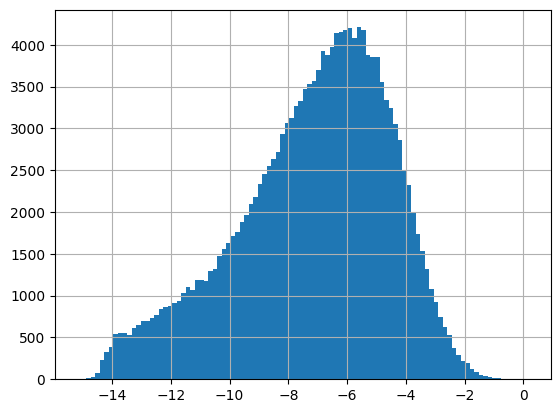

In [29]:
# Take a look at the distribution of the first element of `mfcc_vect` of the training data
train_data_new["mfcc_vect"].apply(lambda x: x[0]).hist(bins=100)

In [30]:
# For the purpose of traning speed, we will normalize the `mfcc_vect` by z-score normalization
# The dimension of `mfcc_vect` is (195, ), so we will normalize the `mfcc_vect` by subtracting the mean and dividing by the standard deviation
v_mean = np.mean(train_data_new["mfcc_vect"].values.tolist(), axis=0)
print(v_mean)
v_std = np.std(train_data_new["mfcc_vect"].values.tolist(), axis=0)
print(v_std)
train_data_new["mfcc_vect_normalized"] = train_data_new["mfcc_vect"].apply(
    lambda x: (x - v_mean) / v_std
)
# Normalize the `mfcc_vect` of the core test set
core_test_data["mfcc_vect_normalized"] = core_test_data["mfcc_vect"].apply(
    lambda x: (x - v_mean) / v_std
)

[ -7.17632055  -9.18600769 -12.58601041  -7.47282439 -17.39754632
 -13.76377724 -11.9275359  -10.13499048  -2.62497108  -6.62489082
  -2.83667144  -4.18970005  -4.52006548  -7.4509234   -7.51357338
 -11.29513359  -4.68955163 -15.59592164 -11.28890717  -9.45438739
  -8.35050417  -0.89694192  -5.73420765  -1.27789811  -3.19725737
  -3.6832879   -7.57726622  -7.91903792 -11.16586106  -4.75362632
 -15.50709087 -11.19543431  -9.30752709  -8.08604108  -0.89696755
  -5.6959436   -1.36747982  -3.25105195  -3.67164548  -7.72090165
  -8.19849563 -11.06877824  -4.8643845  -15.36683316 -11.34855244
  -9.65747748  -8.2049448   -1.00608342  -5.69071031  -1.56530557
  -3.38401267  -3.73698569  -8.11997425  -8.52696554 -10.6469009
  -5.04306461 -14.90717927 -11.41138696 -10.03383444  -8.31045775
  -1.24292141  -5.6419952   -1.8286753   -3.48962716  -3.75133624
   0.17307409   0.17307409   0.17307409   0.17307409   0.17307409
   0.67122106   1.24525156   1.33992433   1.69873306   1.69873306
   1.698733

In [31]:
# Now the `mfcc_vect` is normalized, the mean of `mfcc_vect_normalized` should be 0 and the standard deviation should be 1, let's check it
print(
    f"Mean of `mfcc_vect_normalized`: {train_data_new['mfcc_vect_normalized'].apply(np.mean).mean()}"
)
print(
    f"Standard deviation of `mfcc_vect_normalized`: {train_data_new['mfcc_vect_normalized'].apply(np.std).mean()}"
)

Mean of `mfcc_vect_normalized`: 4.363791785928727e-16
Standard deviation of `mfcc_vect_normalized`: 0.951368242147369


In [32]:
# Get `X_train` and `y_train` from `train_data_new`
X_train = np.array(train_data_new["mfcc_vect_normalized"].values.tolist())
y_train = np.array(train_data_new["class"].values.tolist())
# Get `X_test` and `y_test` from `core_test_data`
X_test = np.array(core_test_data["mfcc_vect_normalized"].values.tolist())
y_test = np.array(core_test_data["class"].values.tolist())

In [33]:
# Take a look at the shape of `X_train` and `y_train`
print(f"Shape of `X_train`: {X_train.shape}")
print(f"Shape of `y_train`: {y_train.shape}")
# Take a look at the shape of `X_test` and `y_test`
print(f"Shape of `X_test`: {X_test.shape}")
print(f"Shape of `y_test`: {y_test.shape}")

Shape of `X_train`: (165424, 195)
Shape of `y_train`: (165424,)
Shape of `X_test`: (8485, 195)
Shape of `y_test`: (8485,)


In [37]:
import tensorflow as tf
from tensorflow.keras import layers

# define the input shape
input_shape = (195,)

# define the model
model = tf.keras.models.Sequential(
    [
        layers.Dense(195, activation="relu", input_shape=input_shape),
        layers.Dense(195, activation="relu"),
        layers.Dense(195, activation="relu"),
        layers.Dense(58, activation="softmax"),  # 58 classes
    ]
)

# compile the model
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# print a summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 195)               38220     
                                                                 
 dense_4 (Dense)             (None, 195)               38220     
                                                                 
 dense_5 (Dense)             (None, 195)               38220     
                                                                 
 dense_6 (Dense)             (None, 58)                11368     
                                                                 
Total params: 126028 (492.30 KB)
Trainable params: 126028 (492.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
5170/5170 [==============================] - 6s 1ms/step - loss: 1.6822 - accuracy: 0.4696 - val_loss: 1.5582 - val_accuracy: 0.4955
Epoch 2/10
5170/5170 [==============================] - 5s 1ms/step - loss: 1.4592 - accuracy: 0.5295 - val_loss: 1.4827 - val_accuracy: 0.5180
Epoch 3/10
5170/5170 [==============================] - 5s 1ms/step - loss: 1.3867 - accuracy: 0.5489 - val_loss: 1.4639 - val_accuracy: 0.5241
Epoch 4/10
5170/5170 [==============================] - 5s 1ms/step - loss: 1.3440 - accuracy: 0.5609 - val_loss: 1.4608 - val_accuracy: 0.5352
Epoch 5/10
5170/5170 [==============================] - 5s 1ms/step - loss: 1.3141 - accuracy: 0.5701 - val_loss: 1.4133 - val_accuracy: 0.5420
Epoch 6/10
5170/5170 [==============================] - 5s 1ms/step - loss: 1.2884 - accuracy: 0.5761 - val_loss: 1.4096 - val_accuracy: 0.5466
Epoch 7/10
5170/5170 [==============================] - 5s 1ms/step - loss: 1.2678 - accuracy: 0.5843 - val_loss: 1.4098 - val_accuracy:

In [39]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

266/266 [==============================] - 0s 582us/step - loss: 1.4092 - accuracy: 0.5542
